# How to Run MMLU with Generative Models (Hugging Face Transformers)
Based on: https://github.com/FranxYao/chain-of-thought-hub/blob/main/MMLU/run_mmlu_open_source.py

In [1]:
import json
import os
import time
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

In [2]:
!git clone https://github.com/FranxYao/chain-of-thought-hub

Cloning into 'chain-of-thought-hub'...
remote: Enumerating objects: 3043, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 3043 (delta 191), reused 247 (delta 179), pack-reused 2704
Receiving objects: 100% (3043/3043), 8.30 MiB | 28.24 MiB/s, done.
Resolving deltas: 100% (964/964), done.


In [3]:
HF_CACHE_LOCATION = "/data/shk148/models/opt/cache"

TASKS = [
        'abstract_algebra',
        'anatomy',
        'astronomy',
        'business_ethics',
        'clinical_knowledge',
        'college_biology',
        'college_chemistry',
        'college_computer_science',
        'college_mathematics',
        'college_medicine',
        'college_physics',
        'computer_security',
        'conceptual_physics',
        'econometrics',
        'electrical_engineering',
        'elementary_mathematics',
        'formal_logic',
        'global_facts',
        'high_school_biology',
        'high_school_chemistry',
        'high_school_computer_science',
        'high_school_european_history',
        'high_school_geography',
        'high_school_government_and_politics',
        'high_school_macroeconomics',
        'high_school_mathematics',
        'high_school_microeconomics',
        'high_school_physics',
        'high_school_psychology',
        'high_school_statistics',
        'high_school_us_history',
        'high_school_world_history',
        'human_aging',
        'human_sexuality',
        'international_law',
        'jurisprudence',
        'logical_fallacies',
        'machine_learning',
        'management',
        'marketing',
        'medical_genetics',
        'miscellaneous',
        'moral_disputes',
        'moral_scenarios',
        'nutrition',
        'philosophy',
        'prehistory',
        'professional_accounting',
        'professional_law',
        'professional_medicine',
        'professional_psychology',
        'public_relations',
        'security_studies', 
        'sociology',
        'us_foreign_policy',
        'virology',
        'world_religions'
        ]

choices = ["A", "B", "C", "D"]
DATA_DIR = "/kaggle/working/chain-of-thought-hub/MMLU/data/"

In [4]:
# Helper Functions: Largely unchanged from https://github.com/FranxYao/chain-of-thought-hub/blob/main/MMLU/run_mmlu_open_source.py

def compute_metric(output_filename):
    with open(output_filename, 'r') as f:
        run_results = json.load(f)
    total_acc = 0
    total_num = 0
    for task in run_results:
        acc = 0
        pred_answers = run_results[task]['pred_answers']
        gold_answers = run_results[task]['gold_answers']
        for pred, gold in zip(pred_answers, gold_answers):
            if pred == gold: acc += 1
        print("ACC-%s: %.4f" % (task, acc/len(gold_answers)))
        total_acc += acc
        total_num += len(gold_answers)
    print("ACC-all: %.4f" % (total_acc/total_num))


def format_subject(subject):
    l = subject.split("_")
    s = ""
    for entry in l:
        s += " " + entry
    return s

def format_example(df, idx, include_answer=True):
    prompt = df.iloc[idx, 0]
    k = df.shape[1] - 2
    for j in range(k):
        prompt += "\n{}. {}".format(choices[j], df.iloc[idx, j+1])
    prompt += "\nAnswer:"
    if include_answer:
        prompt += " {}\n\n".format(df.iloc[idx, k + 1])
    return prompt

def gen_prompt(train_df, subject, k=-1):
    prompt = "The following are multiple choice questions (with answers) about {}.\n\n".format(format_subject(subject))
    if k == -1:
        k = train_df.shape[0]
    for i in range(k):
        prompt += format_example(train_df, i)
    return prompt

def prepare_input(tokenizer, prompts):
    input_tokens = tokenizer.batch_encode_plus(prompts, return_tensors="pt", padding=True)
    input_tokens = {k:input_tokens[k] for k in input_tokens if k in ["input_ids", "attention_mask"]}
    for t in input_tokens:
        if torch.is_tensor(input_tokens[t]):
            input_tokens[t] = input_tokens[t].to('cuda')

    return input_tokens

def batch_split(prompts, batch_num):
    batch_prompts = []
    mini_batch = []
    for prompt in prompts:
        mini_batch.append(prompt)
        if len(mini_batch) == batch_num:
            batch_prompts.append(mini_batch)
            mini_batch = []
    if len(mini_batch) != 0:
        batch_prompts.append(mini_batch)
    return batch_prompts

def batch_infer(model, tokenizer, prompts):
    batch_size = 8
    answers = []
    for batch_input in tqdm(batch_split(prompts, batch_size)):
        encode_inputs = prepare_input(tokenizer, batch_input)
        outputs = model.generate(**encode_inputs, max_new_tokens=1, pad_token_id=tokenizer.pad_token_id)
        answers.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    answers = [answer[-1] for answer in answers]
    return answers


In [5]:
def load(checkpoint, model_type):
    n_gpus = torch.cuda.device_count()
    
    model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=HF_CACHE_LOCATION).cuda()
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=HF_CACHE_LOCATION, padding_side='left')      
    model.eval()
    return model, tokenizer

In [6]:
def main(ckpt_dir: str, param_size: str, model_type: str):
    
    run_results = {}
    output_filename = 'run_results_%s_%sb.json' % (model_type, param_size)
    
    model, tokenizer = load(ckpt_dir, model_type)
    start_time = time.time()
    all_records = []
    for task in TASKS:
        print('Testing %s ...' % task)
        records = []
        dev_df = pd.read_csv(os.path.join(DATA_DIR, "dev", task + "_dev.csv"), header=None)[:5]
        test_df = pd.read_csv(os.path.join(DATA_DIR, "test", task + "_test.csv"), header=None)
        for i in range(test_df.shape[0]):
            # get prompt and make sure it fits
            k = 5
            prompt_end = format_example(test_df, i, include_answer=False)
            train_prompt = gen_prompt(dev_df, task, k)
            prompt = train_prompt + prompt_end
            while len(tokenizer.tokenize(prompt)) + 1> 2048: # bos token
                prompt_split = prompt.split("\n\n")
                prompt_split.pop(1)
                prompt = '\n\n'.join(prompt_split)
#             print(prompt)
            label = test_df.iloc[i, test_df.shape[1]-1]
            records.append({'prompt':prompt, 'answer':label})

        pred_answers = batch_infer(model, tokenizer, [record['prompt'] for record in records])
        gold_answers = [record['answer'] for record in records]
        all_records.append(records)
        run_results[task] = {'pred_answers':pred_answers, 'gold_answers':gold_answers}
    with open(output_filename, 'w') as f:
        json.dump(run_results, f, ensure_ascii=False, indent=2)
    
    compute_metric(output_filename)
    end_time = time.time()
    print("total run time %.2f" % (end_time - start_time))
    del model
    del tokenizer
    return run_results

In [7]:

draft_models = [
	"facebook/opt-350m"
]
rslt = dict()

for draft_model in draft_models:
    rslt[draft_model] =  main(draft_model, draft_model.replace("facebook/opt-", ""), "OPT")
    gc.collect()
    torch.cuda.empty_cache()
# rslt[draft_model]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Testing abstract_algebra ...


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Testing anatomy ...


100%|██████████| 17/17 [00:07<00:00,  2.36it/s]


Testing astronomy ...


100%|██████████| 19/19 [00:12<00:00,  1.56it/s]


Testing business_ethics ...


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Testing clinical_knowledge ...


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Testing college_biology ...


100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


Testing college_chemistry ...


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Testing college_computer_science ...


100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Testing college_mathematics ...


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Testing college_medicine ...


100%|██████████| 22/22 [00:18<00:00,  1.21it/s]


Testing college_physics ...


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Testing computer_security ...


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Testing conceptual_physics ...


100%|██████████| 30/30 [00:08<00:00,  3.34it/s]


Testing econometrics ...


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Testing electrical_engineering ...


100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Testing elementary_mathematics ...


100%|██████████| 48/48 [00:25<00:00,  1.89it/s]


Testing formal_logic ...


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


Testing global_facts ...


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Testing high_school_biology ...


100%|██████████| 39/39 [00:22<00:00,  1.71it/s]


Testing high_school_chemistry ...


100%|██████████| 26/26 [00:13<00:00,  1.89it/s]


Testing high_school_computer_science ...


100%|██████████| 13/13 [00:14<00:00,  1.12s/it]


Testing high_school_european_history ...


100%|██████████| 21/21 [01:01<00:00,  2.95s/it]


Testing high_school_geography ...


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Testing high_school_government_and_politics ...


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Testing high_school_macroeconomics ...


100%|██████████| 49/49 [00:19<00:00,  2.50it/s]


Testing high_school_mathematics ...


100%|██████████| 34/34 [00:19<00:00,  1.79it/s]


Testing high_school_microeconomics ...


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Testing high_school_physics ...


100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


Testing high_school_psychology ...


100%|██████████| 69/69 [00:38<00:00,  1.79it/s]


Testing high_school_statistics ...


100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Testing high_school_us_history ...


100%|██████████| 26/26 [01:16<00:00,  2.94s/it]


Testing high_school_world_history ...


100%|██████████| 30/30 [01:06<00:00,  2.22s/it]


Testing human_aging ...


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Testing human_sexuality ...


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Testing international_law ...


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Testing jurisprudence ...


100%|██████████| 14/14 [00:05<00:00,  2.37it/s]


Testing logical_fallacies ...


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Testing machine_learning ...


100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


Testing management ...


100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


Testing marketing ...


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Testing medical_genetics ...


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Testing miscellaneous ...


100%|██████████| 98/98 [00:31<00:00,  3.07it/s]


Testing moral_disputes ...


100%|██████████| 44/44 [00:22<00:00,  1.94it/s]


Testing moral_scenarios ...


100%|██████████| 112/112 [01:17<00:00,  1.45it/s]


Testing nutrition ...


100%|██████████| 39/39 [00:24<00:00,  1.61it/s]


Testing philosophy ...


100%|██████████| 39/39 [00:14<00:00,  2.71it/s]


Testing prehistory ...


100%|██████████| 41/41 [00:22<00:00,  1.81it/s]


Testing professional_accounting ...


100%|██████████| 36/36 [00:25<00:00,  1.40it/s]


Testing professional_law ...


100%|██████████| 192/192 [08:13<00:00,  2.57s/it]


Testing professional_medicine ...


100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


Testing professional_psychology ...


100%|██████████| 77/77 [00:50<00:00,  1.53it/s]


Testing public_relations ...


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Testing security_studies ...


100%|██████████| 31/31 [00:50<00:00,  1.63s/it]


Testing sociology ...


100%|██████████| 26/26 [00:11<00:00,  2.22it/s]


Testing us_foreign_policy ...


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Testing virology ...


100%|██████████| 21/21 [00:07<00:00,  2.82it/s]


Testing world_religions ...


100%|██████████| 22/22 [00:05<00:00,  3.85it/s]


ACC-abstract_algebra: 0.2200
ACC-anatomy: 0.2667
ACC-astronomy: 0.1776
ACC-business_ethics: 0.2100
ACC-clinical_knowledge: 0.2679
ACC-college_biology: 0.2361
ACC-college_chemistry: 0.3200
ACC-college_computer_science: 0.2800
ACC-college_mathematics: 0.2700
ACC-college_medicine: 0.2486
ACC-college_physics: 0.2157
ACC-computer_security: 0.1900
ACC-conceptual_physics: 0.3064
ACC-econometrics: 0.2281
ACC-electrical_engineering: 0.3310
ACC-elementary_mathematics: 0.2566
ACC-formal_logic: 0.2778
ACC-global_facts: 0.1900
ACC-high_school_biology: 0.3000
ACC-high_school_chemistry: 0.3153
ACC-high_school_computer_science: 0.1800
ACC-high_school_european_history: 0.2606
ACC-high_school_geography: 0.3586
ACC-high_school_government_and_politics: 0.3472
ACC-high_school_macroeconomics: 0.2897
ACC-high_school_mathematics: 0.2778
ACC-high_school_microeconomics: 0.2773
ACC-high_school_physics: 0.3377
ACC-high_school_psychology: 0.3358
ACC-high_school_statistics: 0.4722
ACC-high_school_us_history: 0.2304

In [8]:
import pandas as pd

def transform_all_tasks(run_results):
    """
    Transforms all tasks in run_results dictionary to a single DataFrame.

    Args:
      run_results: Dictionary containing results for multiple tasks.

    Returns:
      pandas.DataFrame: DataFrame with columns 'task_name' (optional), 'prompt' (optional), 'prediction' and 'gold_label'.
    """
    data = []
    for task_name, task_results in run_results.items():
        # Check if 'prompt' key exists in task_results
        if 'prompt' in task_results:
            prompts = task_results['prompt']
            for i in range(len(prompts)):
                data.append({
                'task_name': task_name,
                'prompt': prompts[i],
                'prediction': task_results['pred_answers'][i],
                'gold_label': task_results['gold_answers'][i]
                })
        else:
            for i in range(len(task_results['pred_answers'])):
                data.append({
                'task_name': task_name,
                'prediction': task_results['pred_answers'][i],
                'gold_label': task_results['gold_answers'][i]
                })
    return pd.DataFrame(data)

# Transform all tasks in run_results to DataFrame
df = transform_all_tasks(rslt[draft_model])
# print(df)


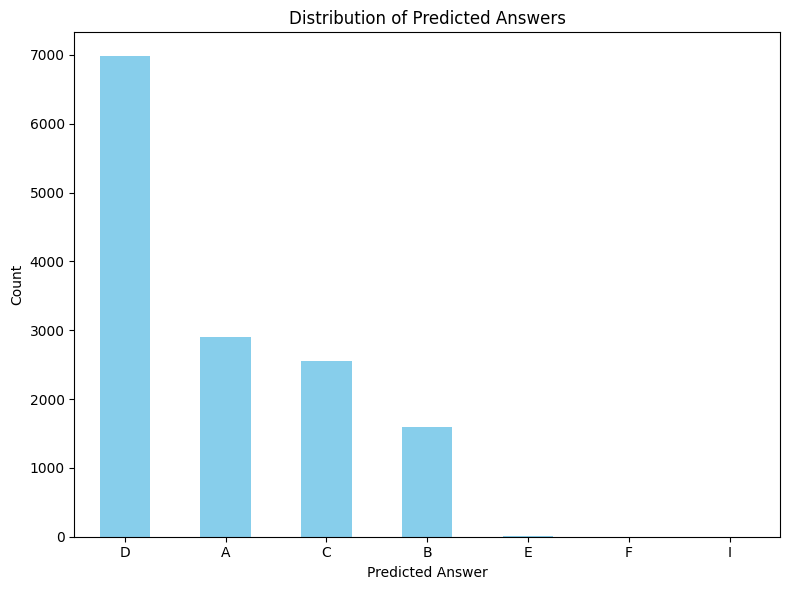

In [9]:
import matplotlib.pyplot as plt

def analyze_predictions(df):
    """
    Analyzes predicted answers from a CSV file and creates a bar chart.

    Args:
      filename: Path to the CSV file containing "predicted_answer" column.
    """

    # Count occurrences of each predicted answer
    answer_counts = df['prediction'].value_counts()

    # Create bar chart
    plt.figure(figsize=(8, 6))
    answer_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Predicted Answer')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Answers')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

analyze_predictions(df)
